<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Libraries" data-toc-modified-id="Libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Libraries</a></span></li><li><span><a href="#Data" data-toc-modified-id="Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data</a></span></li><li><span><a href="#Data-Preparation" data-toc-modified-id="Data-Preparation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data Preparation</a></span></li><li><span><a href="#Data-exploration-and-visualization" data-toc-modified-id="Data-exploration-and-visualization-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Data exploration and visualization</a></span><ul class="toc-item"><li><span><a href="#Visualizations-by-player-(data-since-2016)" data-toc-modified-id="Visualizations-by-player-(data-since-2016)-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Visualizations by player (data since 2016)</a></span></li><li><span><a href="#Visualizations-by-Year" data-toc-modified-id="Visualizations-by-Year-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Visualizations by Year</a></span></li><li><span><a href="#Wacky-Tangotiger-Shit" data-toc-modified-id="Wacky-Tangotiger-Shit-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Wacky Tangotiger Shit</a></span></li></ul></li></ul></div>

# 3.0 Launch Angle Profiles
Investigating different players' launch angles visually, because averages suck.

## Libraries

In [6]:
import pandas as pd
import numpy as np
import mysql.connector
from sqlalchemy import create_engine

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline
sns.set(rc={'figure.figsize':(16,9)})

## Data

In [7]:
engine = create_engine('mysql+mysqlconnector://{username}:{password}@{host}/{db}'.format(**{
    'username': 'mlb-db',
    'password': 'password',
    'host': 'localhost',
    'db': 'mlbdb'
  }), echo=False)

In [8]:
params = {
    'year_filter': 'game_year >= 2016',
    'game_type': 'R'
}

In [9]:
SQL = \
"""
SELECT
  t_events.event_id AS event_id,
  t_events.batter_id AS batter_id,
  t_batter.mlb_name AS batter_name,
  t_events.pitcher_id AS pitcher_id,
  t_pitcher.mlb_name AS pitcher_name,
  t_events.at_bat_key AS at_bat_key,
  t_events.game_pk AS game_pk,
  t_events.game_year AS game_year,
  t_events.at_bat_number AS at_bat_number,
  t_events.pitch_number AS pitch_number,
  t_events.batter_team AS batter_team,
  t_events.pitcher_team AS pitcher_team,
  t_events.batter_side AS batter_side,
  t_events.pitcher_side AS pitcher_side,
  t_events.description AS description,
  t_events.events AS events,
  t_events.bb_type AS bb_type,
  t_events.release_speed AS release_speed,
  t_events.release_spin_rate AS release_spin_rate,
  t_events.break_horizontal AS break_horizontal,
  t_events.break_vertical AS break_vertical,
  t_events.zone AS zone,
  t_events.plate_x AS plate_x,
  t_events.plate_z AS plate_z,
  t_events.launch_speed AS launch_speed,
  t_events.launch_angle AS launch_angle,
  t_events.spray_angle AS spray_angle,
  t_events.hit_x AS hit_x,
  t_events.hit_y AS hit_y,
  t_events.hit_distance_sc AS hit_distance_sc,
  (CASE WHEN t_events.events IN ('single', 'double', 'triple', 'home_run') THEN 1 ELSE 0 END) AS hit_flag,
  (CASE WHEN t_events.events = 'home_run' THEN 1 ELSE 0 END) AS hr_flag,
  (CASE WHEN t_events.launch_speed IS NOT NULL AND t_events.launch_angle IS NOT NULL AND t_events.hit_distance_sc IS NULL
    THEN 1 ELSE 0 END) AS sc_fill_flag
FROM
  (
    SELECT
      event_id,
      batter AS batter_id,
      pitcher AS pitcher_id,
      CONCAT(game_pk, at_bat_number) AS at_bat_key,
      game_pk,
      at_bat_number,
      pitch_number,
      MAX(game_year) AS game_year,
      MAX(batter_team) AS batter_team,
      MAX(pitcher_team) AS pitcher_team,
      MAX(stand) AS batter_side,
      MAX(p_throws) AS pitcher_side,
      MAX(description) AS description,
      MAX(events) AS events,
      MAX(bb_type) AS bb_type,
      MAX(effective_speed) AS effective_speed,
      MAX(release_speed) AS release_speed,
      MAX(release_spin_rate) AS release_spin_rate,
      MAX(pfx_x) AS break_horizontal,
      MAX(pfx_z) AS break_vertical,
      MAX(zone) AS zone,
      MAX(plate_x) AS plate_x,
      MAX(plate_z) AS plate_z,
      MAX(launch_speed) AS launch_speed,
      MAX(launch_angle) AS launch_angle,
      MAX(spray_angle_est) AS spray_angle,
      MAX(hc_x) AS hit_x,
      MAX(hc_y) AS hit_y,
      MAX(hit_distance_sc) AS hit_distance_sc
    FROM
      `mlbdb`.`statcast_extended`
    WHERE
      {year_filter}
        AND game_type = '{game_type}'
    GROUP BY 1, 2, 3, 4, 5, 6, 7
  ) t_events
    LEFT OUTER JOIN
  (
    SELECT
      mlb_id,
      mlb_name
    FROM
      `mlbdb`.`players`
  ) t_batter
    ON (t_events.batter_id = t_batter.mlb_id)
    LEFT OUTER JOIN
  (
    SELECT
      mlb_id,
      mlb_name
    FROM
      `mlbdb`.`players`
  ) t_pitcher
    ON (t_events.pitcher_id = t_pitcher.mlb_id)
"""

In [11]:
sql = SQL.format(**params)
df_events = pd.read_sql(sql=sql, con=engine)

df_true = df_events.copy()

In [12]:
df_events.head(5)

,event_id,batter_id,batter_name,pitcher_id,pitcher_name,at_bat_key,game_pk,game_year,at_bat_number,pitch_number,...,plate_z,launch_speed,launch_angle,spray_angle,hit_x,hit_y,hit_distance_sc,hit_flag,hr_flag,sc_fill_flag
0,446867.160405_131253.1,605141,Mookie Betts,446372,Corey Kluber,4468671,446867,2016,1,1,...,2.287,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
1,446867.160405_131308.2,605141,Mookie Betts,446372,Corey Kluber,4468671,446867,2016,1,2,...,-0.264,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
2,446867.160405_131328.3,605141,Mookie Betts,446372,Corey Kluber,4468671,446867,2016,1,3,...,2.334,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
3,446867.160405_131345.4,605141,Mookie Betts,446372,Corey Kluber,4468671,446867,2016,1,4,...,2.276,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
4,446867.160405_131414.5,605141,Mookie Betts,446372,Corey Kluber,4468671,446867,2016,1,5,...,1.951,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0


In [13]:
df_events.shape

(1583789, 33)

## Data Preparation

In [14]:
_batted = df_events['bb_type'].notnull()
_hit = df_events['hit_flag'] == 1
_hr = df_events['hr_flag'] == 1
_sc_fill = df_events['sc_fill_flag'] == 1
_rhb = df_events['batter_side'] == 'R'
_lhb = df_events['batter_side'] == 'L'
_rhp = df_events['pitcher_side'] == 'R'
_lhp = df_events['pitcher_side'] == 'L'

## Data exploration and visualization

In [49]:
df_launch = df_events[_batted & ~_sc_fill]
df_launch_no_hr = df_events[_batted & ~_sc_fill & ~_hr]

### Visualizations by player (data since 2016)

In [77]:
batter_list = [
    'Mike Trout',
    'Aaron Judge',
    'Joey Gallo',
    'Ian Desmond'
]
df_player = df_launch[df_launch['batter_name'].isin(batter_list)]
df_player_no_hr = df_launch_no_hr[df_launch_no_hr['batter_name'].isin(batter_list)]

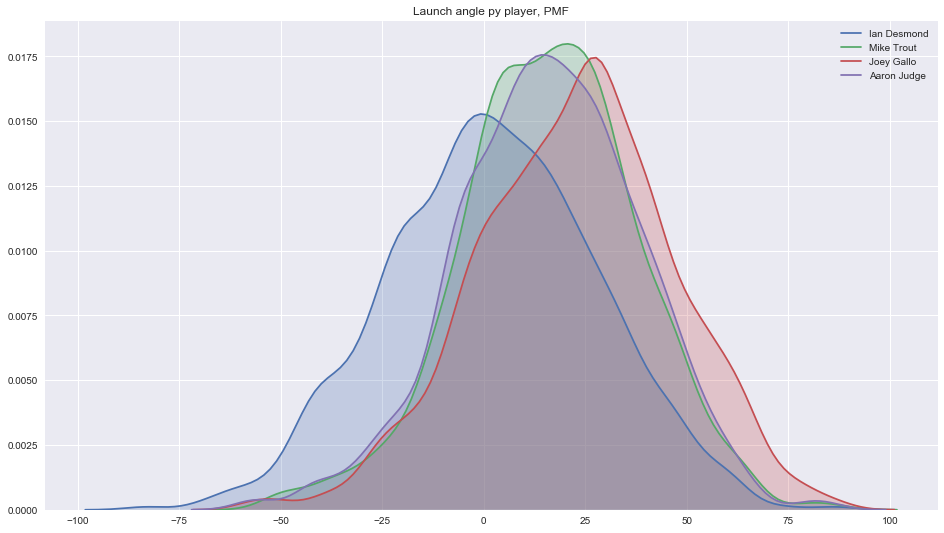

In [78]:
for batter in df_player['batter_name'].unique():
    _df = df_player[df_player['batter_name'] == batter]
    sns.kdeplot(data=_df['launch_angle'], bw=5, label=batter, shade=True)
    
plt.title('Launch angle py player, PMF')
plt.show()

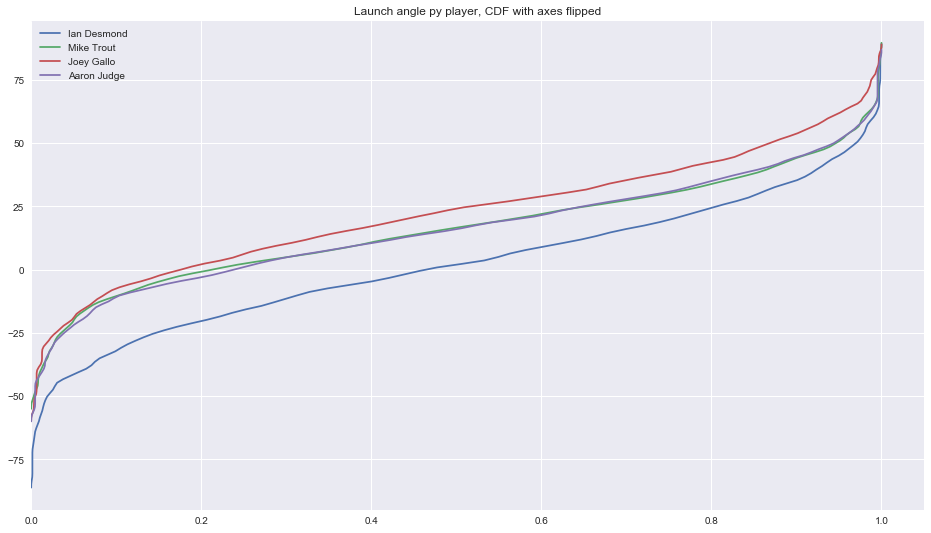

In [80]:
for batter in df_player['batter_name'].unique():
    _df = df_player[df_player['batter_name'] == batter]
    sns.kdeplot(data=_df['launch_angle'], bw=1, label=batter, cumulative=True,
               vertical=True)
    
plt.title('Launch angle py player, CDF with axes flipped')
plt.show()

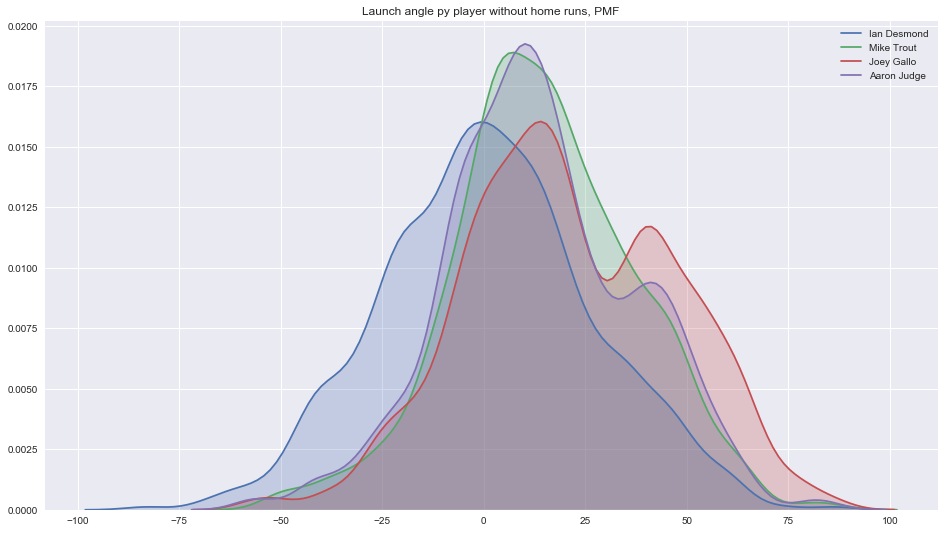

In [81]:
for batter in df_player_no_hr['batter_name'].unique():
    _df = df_player_no_hr[df_player_no_hr['batter_name'] == batter]
    sns.kdeplot(data=_df['launch_angle'], bw=5, label=batter, shade=True)
    
plt.title('Launch angle py player without home runs, PMF')
plt.show()

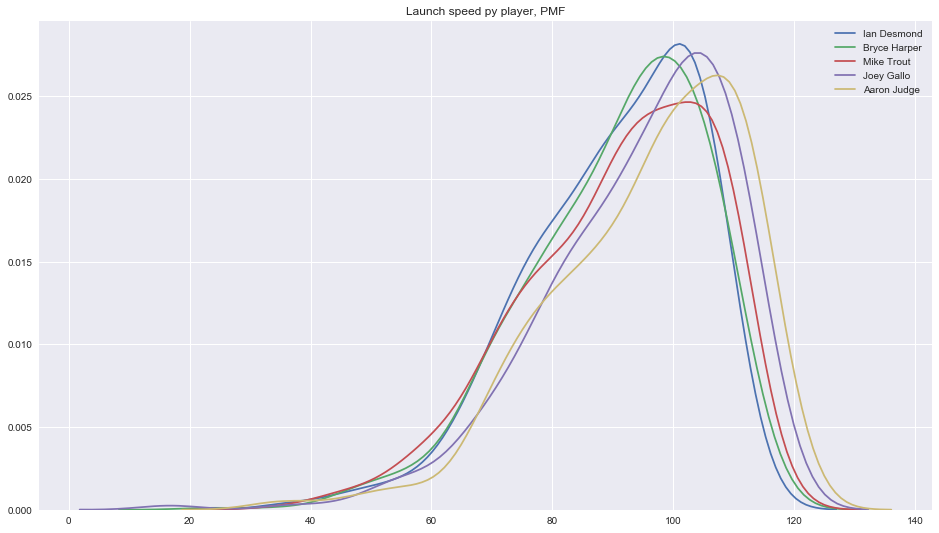

In [64]:
for batter in df_player['batter_name'].unique():
    _df = df_player[df_player['batter_name'] == batter]
    sns.kdeplot(data=_df['launch_speed'], bw=5, label=batter)
    
plt.title('Launch speed py player, PMF')
plt.show()

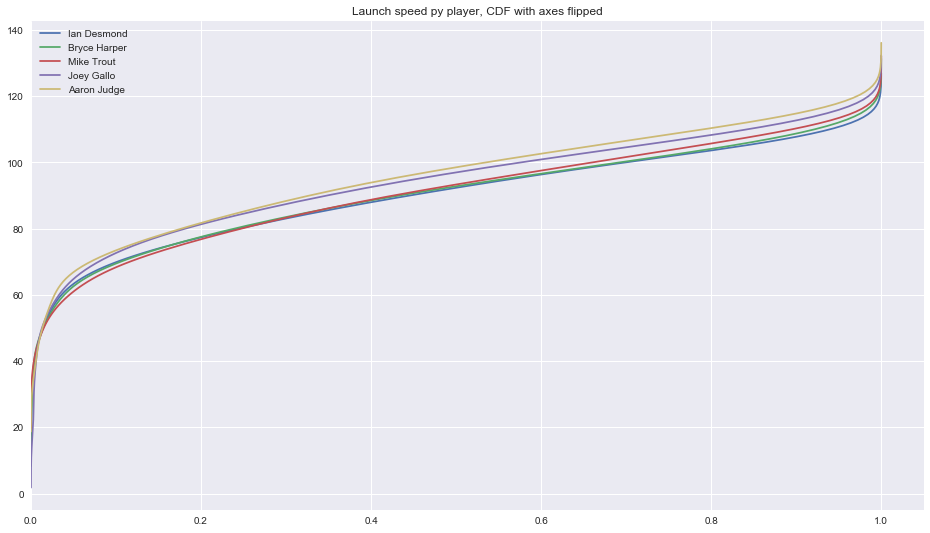

In [65]:
for batter in df_player['batter_name'].unique():
    _df = df_player[df_player['batter_name'] == batter]
    sns.kdeplot(data=_df['launch_speed'], bw=5, label=batter, cumulative=True,
               vertical=True)
    
plt.title('Launch speed py player, CDF with axes flipped')
plt.show()

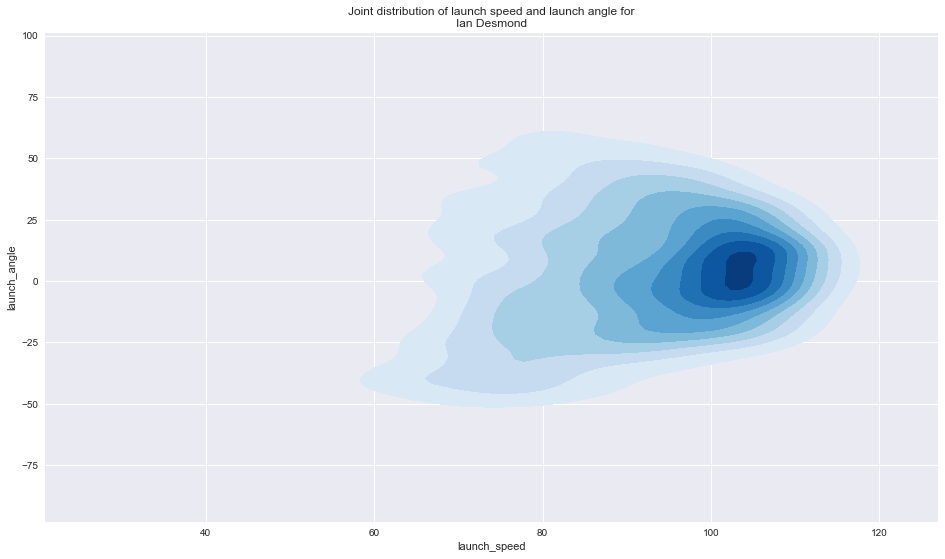

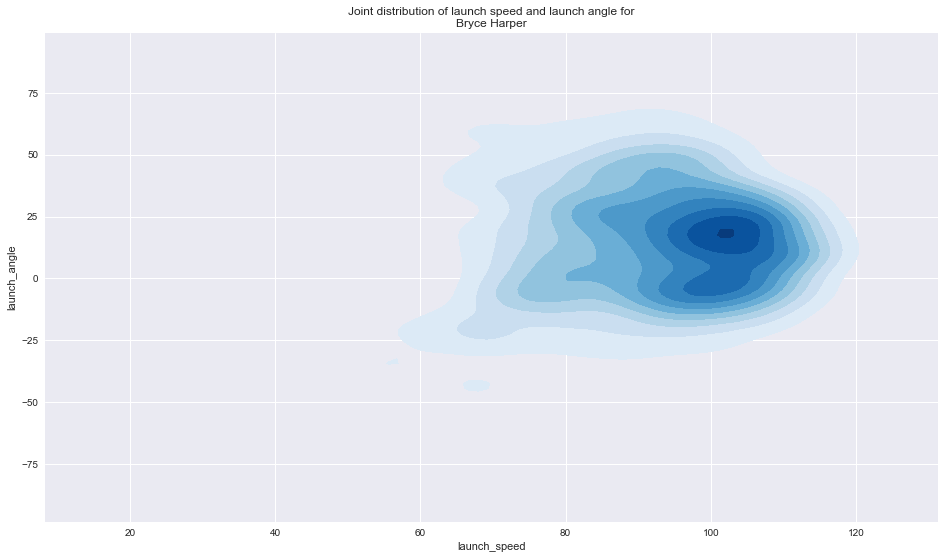

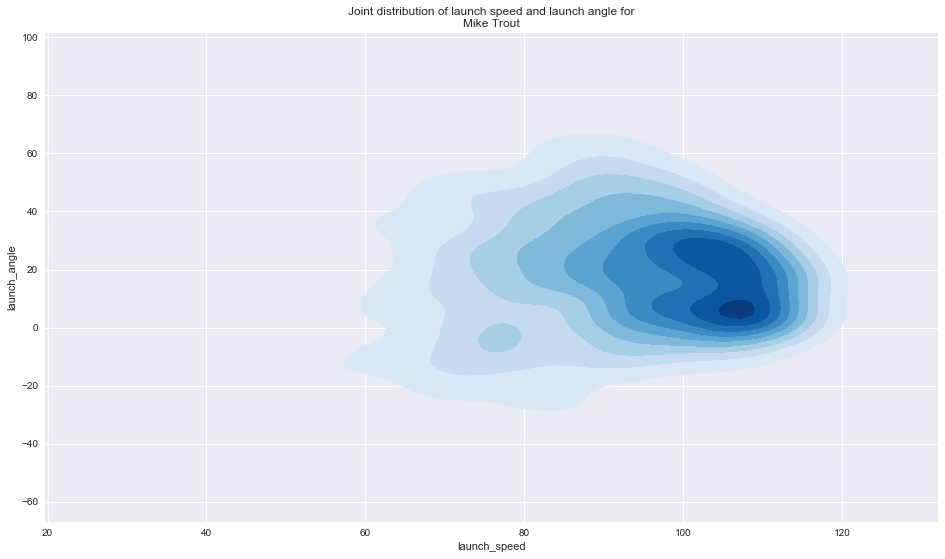

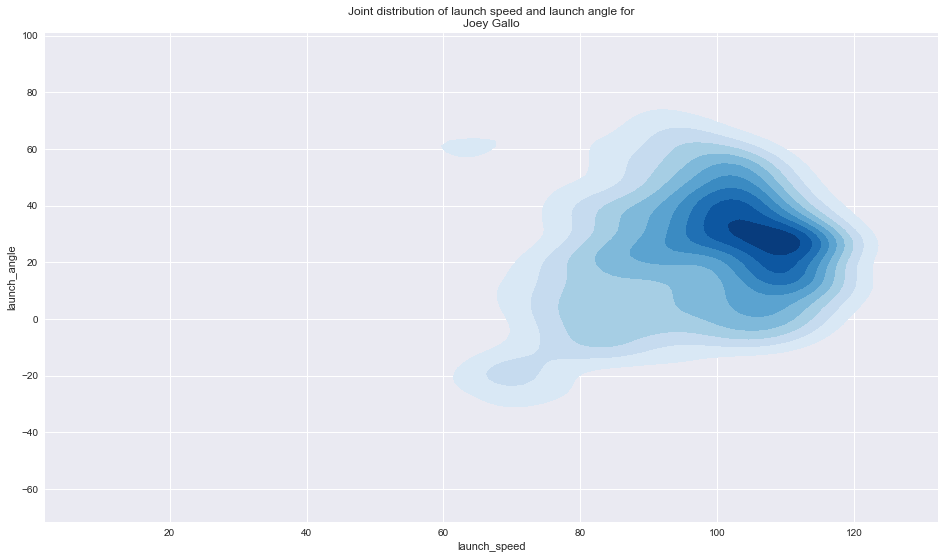

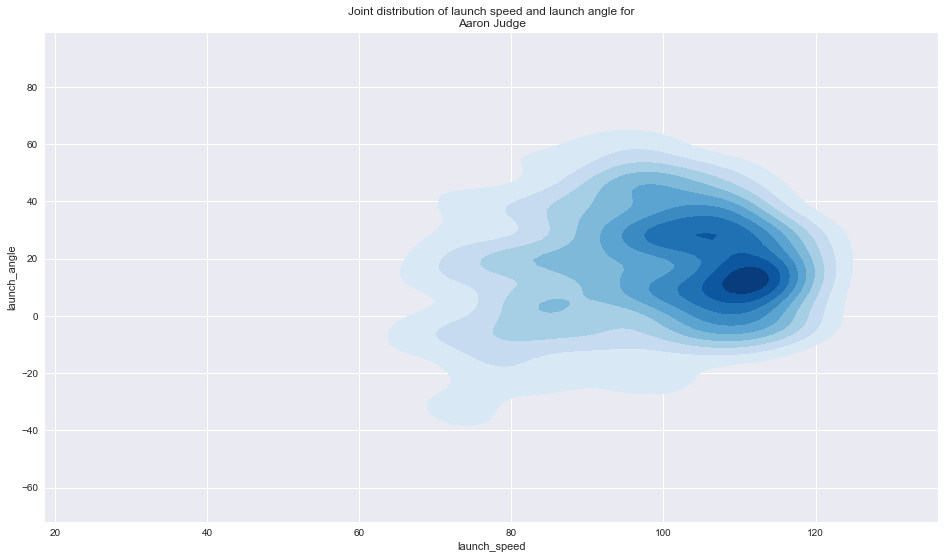

In [69]:
for batter in df_player['batter_name'].unique():
    _df = df_player[df_player['batter_name'] == batter]
    sns.kdeplot(data=_df['launch_speed'], data2=_df['launch_angle'], bw=5, shade=True,
               shade_lowest=False, cmap='Blues')
    
    plt.title('Joint distribution of launch speed and launch angle for\n{}'.format(batter))
    plt.show()

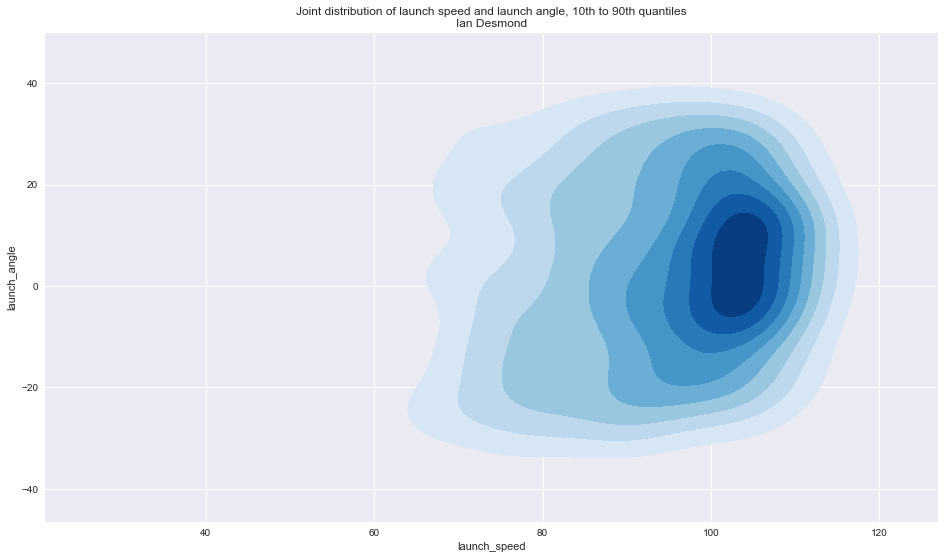

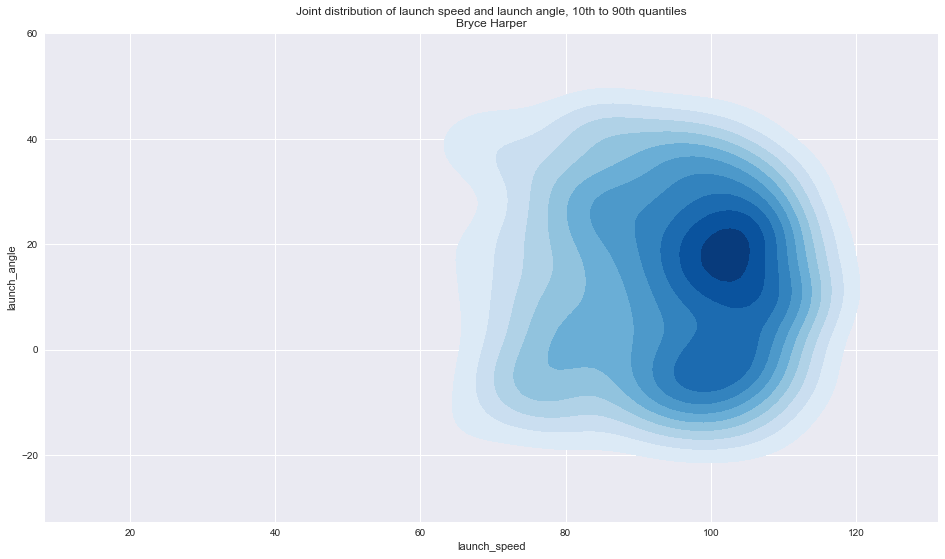

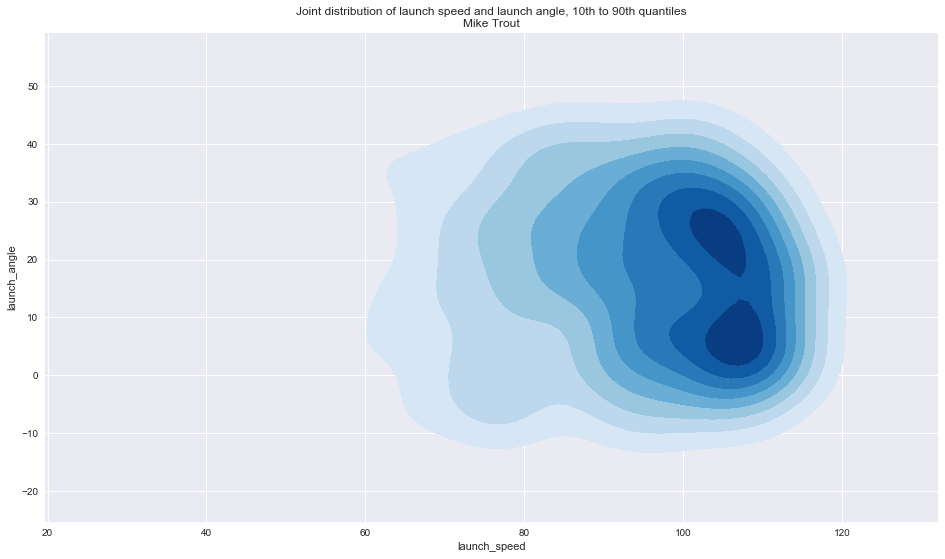

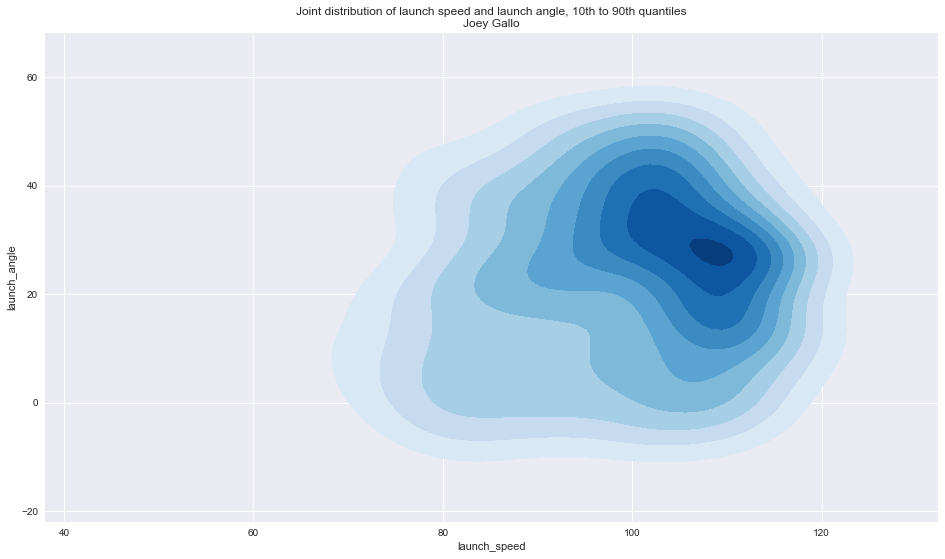

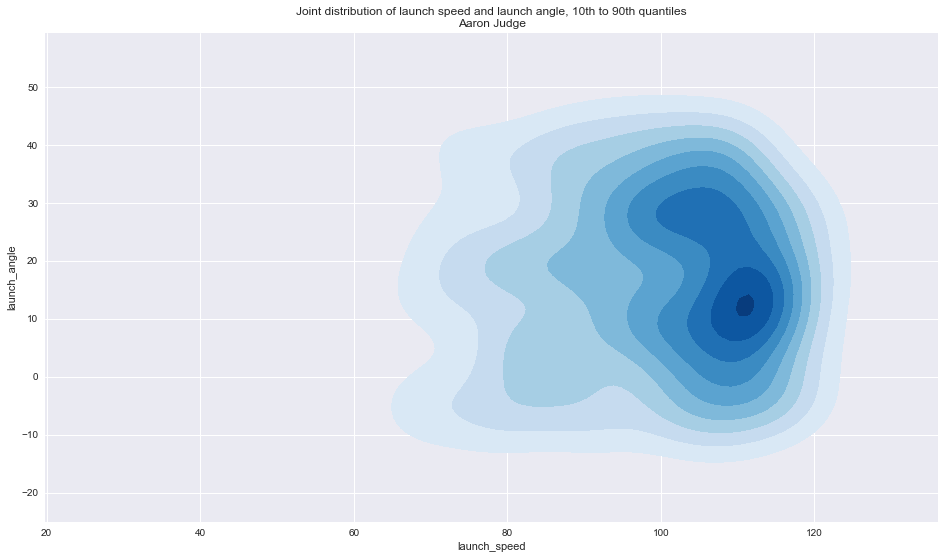

In [75]:
lim_lower = 0.1
lim_higher = 0.9

for batter in df_player['batter_name'].unique():
    _df = df_player[df_player['batter_name'] == batter]
    _low = _df['launch_angle'].quantile(lim_lower)
    _high = _df['launch_angle'].quantile(lim_higher)
    _df = _df[(_df['launch_angle'] > _low) & (_df['launch_angle'] < _high)]
    
    sns.kdeplot(data=_df['launch_speed'], data2=_df['launch_angle'], bw=5, shade=True,
               shade_lowest=False, cmap='Blues')
    
    plt.title('Joint distribution of launch speed and launch angle, {:2.0f}th to {:2.0f}th quantiles\n{}'
              .format(lim_lower * 100, lim_higher * 100, batter))
    plt.show()

### Visualizations by Year

In [51]:
batter_list_yearly = [
    'Mike Trout',
    'Aaron Judge',
    'Joey Gallo',
    'Ian Desmond',
    'Bryce Harper',
    'Didi Gregorius',
    'Gary Sanchez',
    'Brett Gardner',
    'Giancarlo Stanton'
]
df_yearly = df_launch[df_launch['batter_name'].isin(batter_list_yearly)]
df_yearly_no_hr = df_launch_no_hr[df_launch_no_hr['batter_name'].isin(batter_list_yearly)]

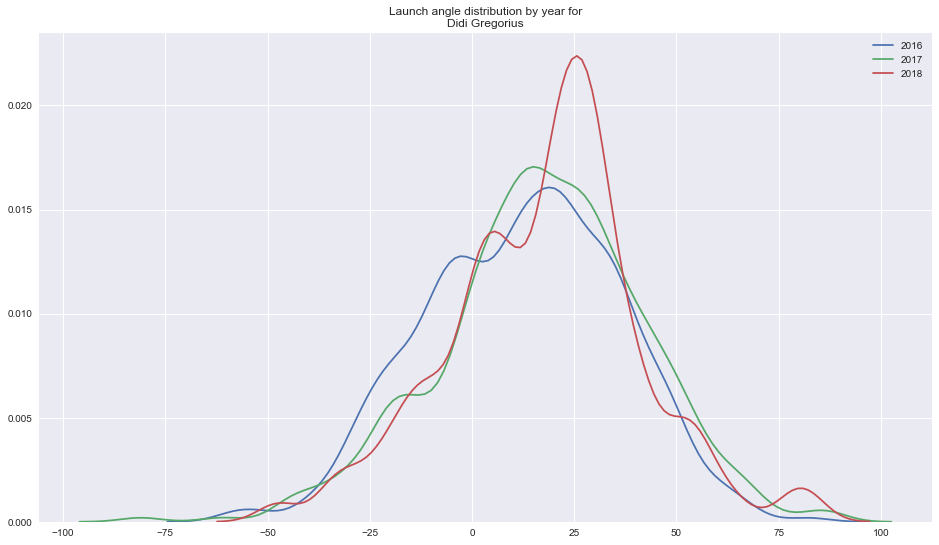

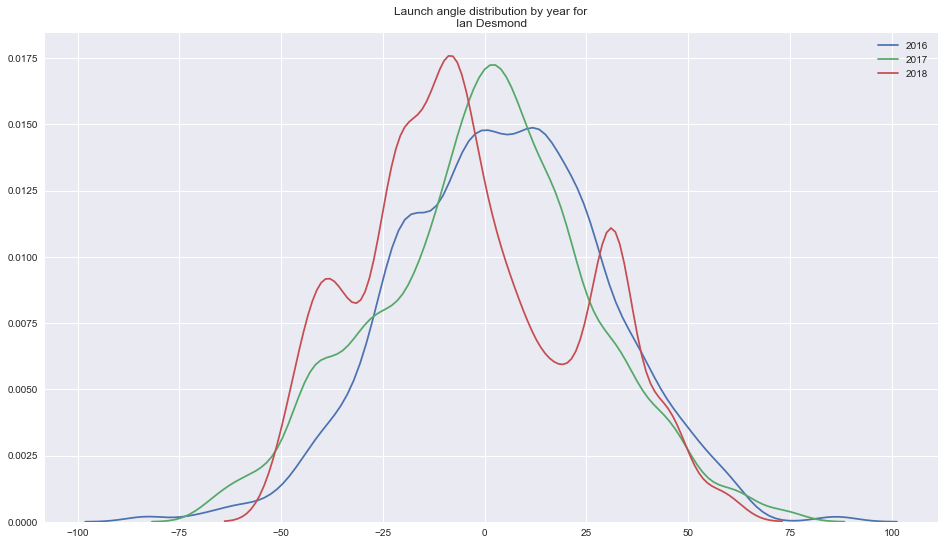

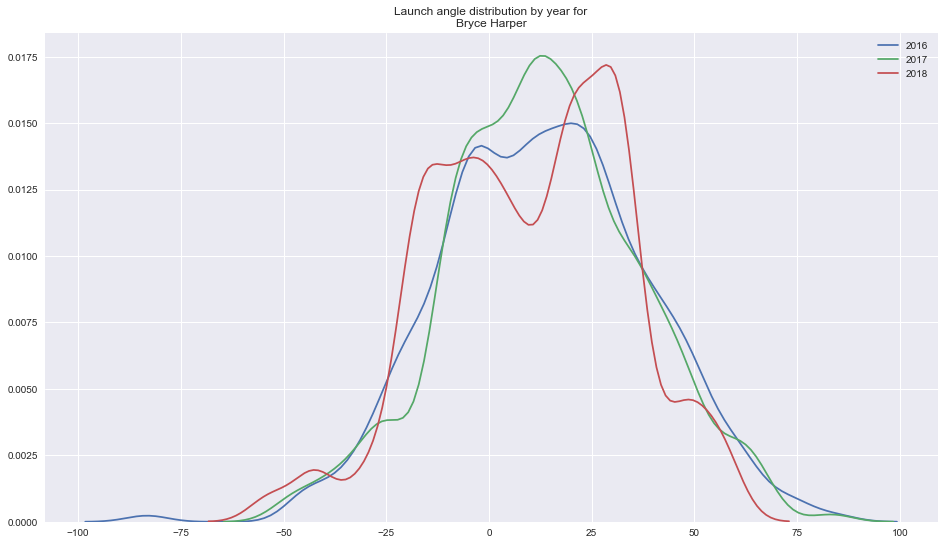

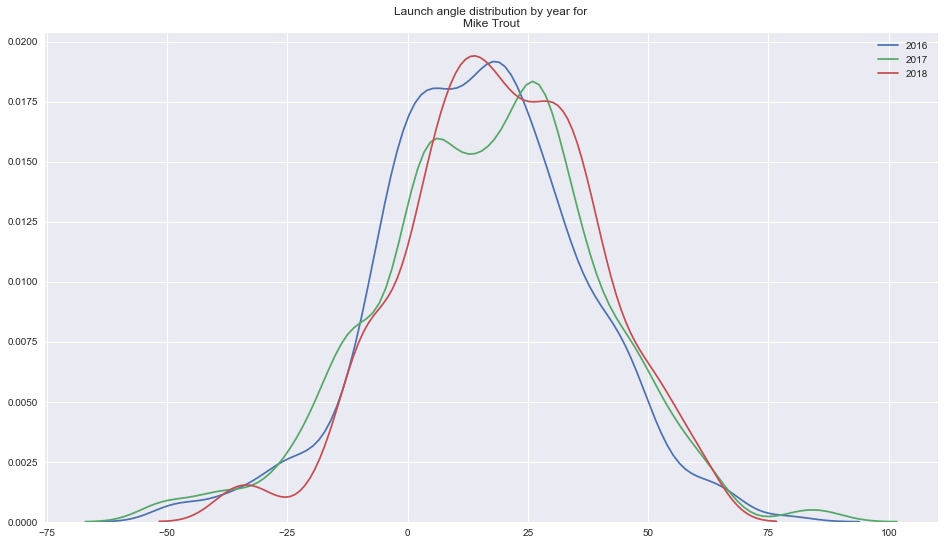

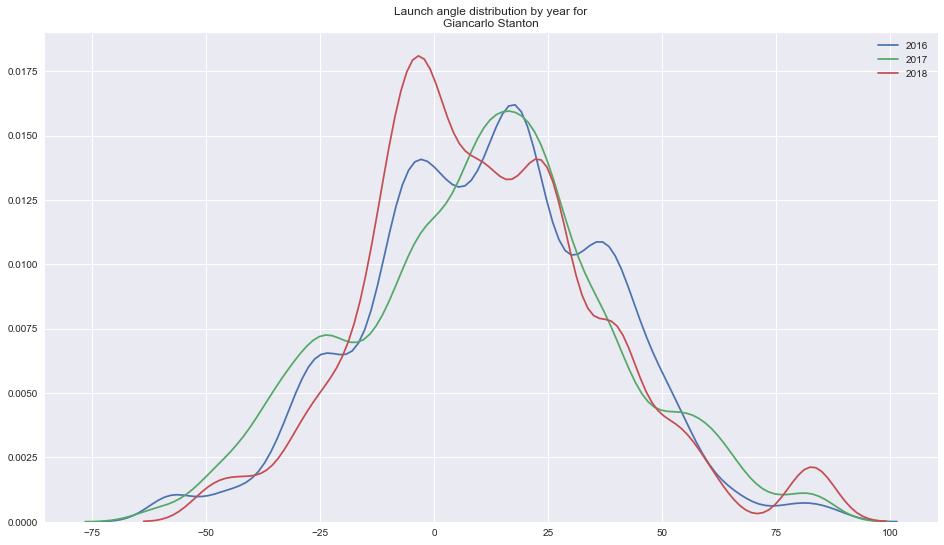

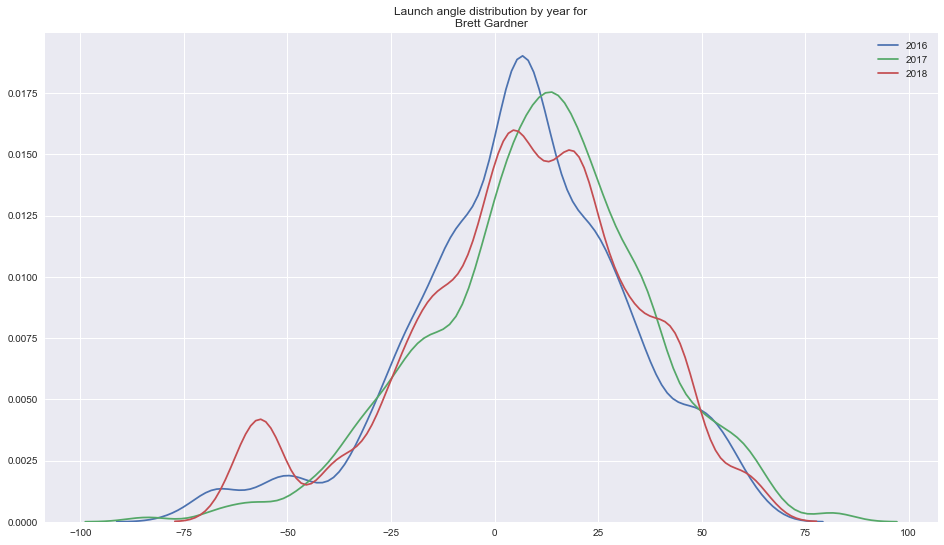

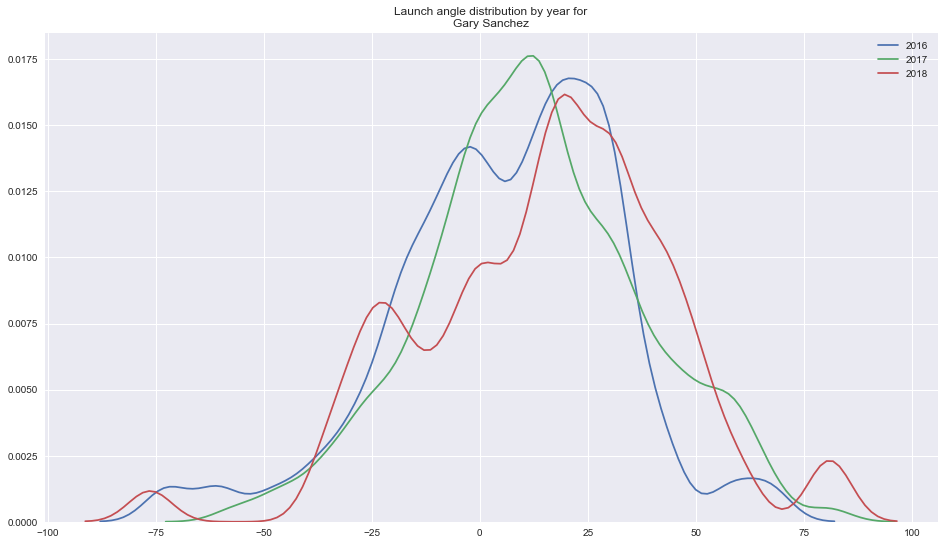

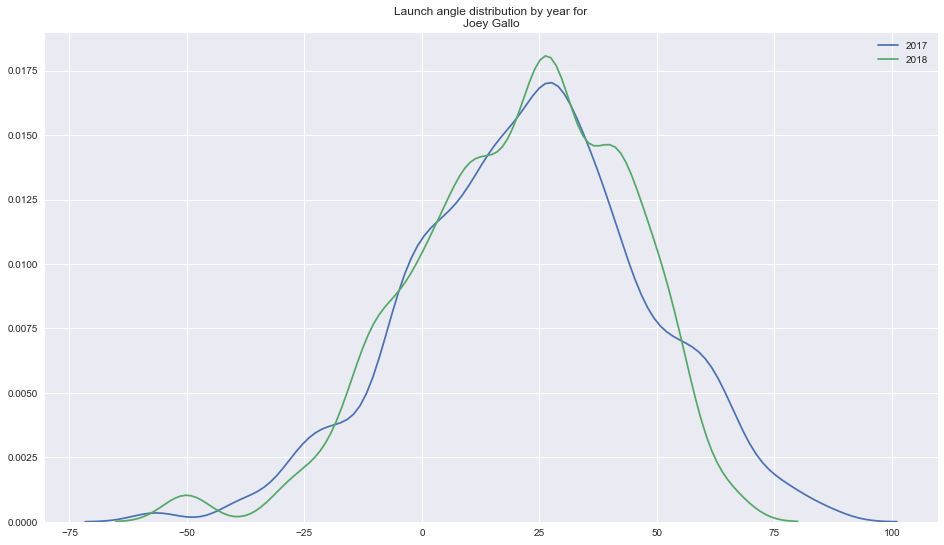

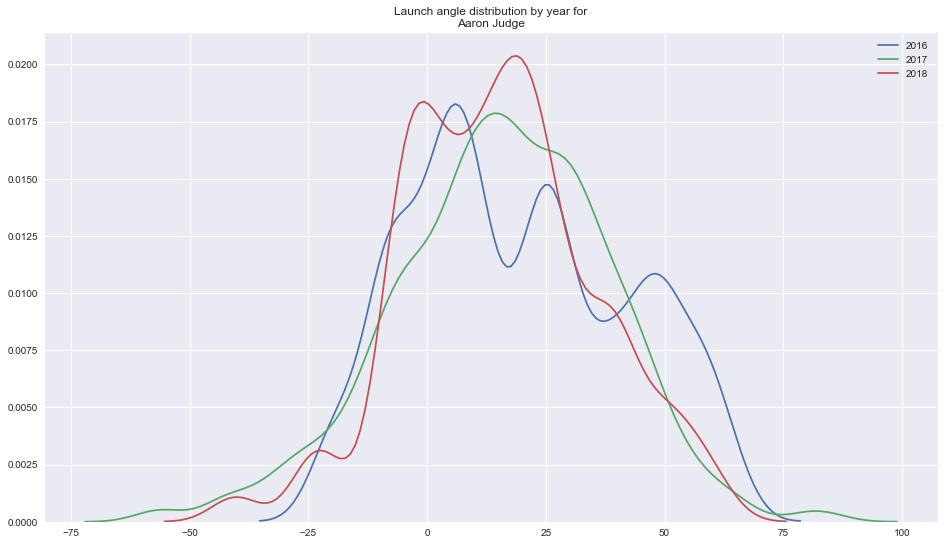

In [68]:
MIN_EVENTS = 25

for batter in df_yearly['batter_name'].unique():
    _df = df_yearly[df_yearly['batter_name'] == batter]
    
    for year in df_yearly['game_year'].unique():
        __df = _df[_df['game_year'] == year]
        
        if __df.shape[0] > MIN_EVENTS:
            sns.kdeplot(data=__df['launch_angle'], bw=5, label=year)

    plt.title('Launch angle distribution by year for\n{}'.format(batter))
    plt.show()

### Wacky Tangotiger Shit

In [56]:
batter_list_tt = [
    'Mike Trout',
    'Aaron Judge',
    'Joey Gallo',
    'Ian Desmond',
    'Bryce Harper'
]
df_tt = df_launch[df_launch['batter_name'].isin(batter_list_tt)]

In [60]:
for batter in df_tt['batter_name'].unique():
    _df = df_tt[df_tt['batter_name'] == batter]
    
    q20 = _df['launch_angle'].quantile(0.20)
    q80 = _df['launch_angle'].quantile(0.80)
    est_med = (q20 + q80) / 2
    
    print(batter)
    print('20: {:2.2f}, 80: {:2.2f}, med: {:2.2f}'.format(q20, q80, est_med))
    print('\n')

Ian Desmond
20: -20.35, 80: 24.32, med: 1.98


Bryce Harper
20: -7.50, 80: 34.01, med: 13.26


Mike Trout
20: -0.93, 80: 33.78, med: 16.42


Joey Gallo
20: 2.51, 80: 42.48, med: 22.50


Aaron Judge
20: -3.13, 80: 34.95, med: 15.91


